In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from logisticSmoothing import smoothedLookupEstimator

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = False
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add FNSTATUS1 and RBC
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]

In [3]:
# Add an intercept
cdf['intercept'] = 1.0

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

In [4]:
X = cdf['AGE']

In [5]:
sle = smoothedLookupEstimator(nBins=512)
tuned_parameters = [{'sigma': np.logspace(-1,1.3,20,base=10)}]
gscv = GridSearchCV(sle,tuned_parameters,cv=10,verbose=1)
gscv.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=smoothedLookupEstimator(modelX=[], modelY=[], nBins=512, sigma=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'sigma': array([  0.1    ,   0.13215,   0.17462,   0.23076,   0.30494,   0.40296,
         0.5325 ,   0.70367,   0.92987,   1.22878,   1.62378,   2.14575,
         2.83551,   3.747  ,   4.9515 ,   6.54319,   8.64654,  11.42601,
        15.09897,  19.95262])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

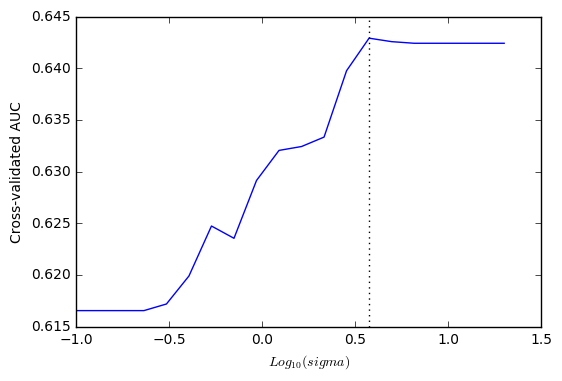

Best sigma = 3.747


In [6]:
gscv.grid_scores_
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params['sigma'] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means)
bestC = gscv.best_params_['sigma']
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}(sigma)$')
plt.ylabel('Cross-validated AUC')
plt.show()
print('Best sigma = %.3f' % bestC)

Bootstrapping confidence intervals...


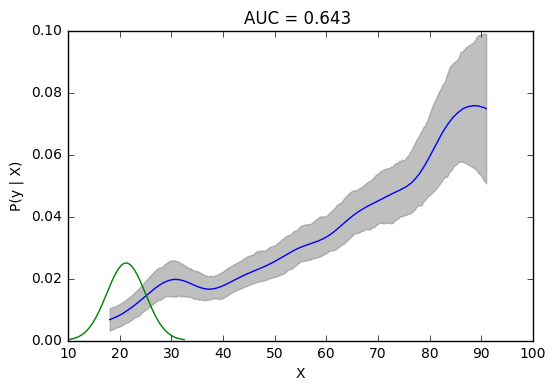

In [7]:
sle = gscv.best_estimator_
sle.bootModelCI(X,y,200,0.05)
sle.plotModel(plt.gca())
plt.title('AUC = %.3f ' % gscv.best_score_)
plt.show()